In [15]:
import pandas as pd
import talib as ta
import numpy as np

In [16]:
def preprocess_stock_data(csv_file_path):
    # Load data from CSV file
    data = pd.read_csv(csv_file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data.set_index('Date', inplace=True)
    
    # Fill missing dates
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data = data.ffill()
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    
    # Convert volume from string to number
    def convert_volume_to_number(volume_str):
        if isinstance(volume_str, float) and np.isnan(volume_str):
            return np.nan
        if volume_str[-1] == 'K':
            return int(float(volume_str[:-1]) * 1000)
        elif volume_str[-1] == 'M':
            return int(float(volume_str[:-1]) * 1000000)
        elif volume_str[-1] == 'B':
            return int(float(volume_str[:-1]) * 1000000000)
        else:
            return int(volume_str)
    
    # Apply convert_volume_to_number function to Volume column
    data["Volume"] = data["Volume"].apply(convert_volume_to_number)
    
    # Convert change % from string to number
    def convert_change_to_number(change_str):
        if isinstance(change_str, float) and np.isnan(change_str):
            return np.nan
        new_change = float(change_str.strip('%')) / 100
        return new_change

    # Apply convert_change_to_number function to Change % column
    data["Change %"] = data["Change %"].apply(convert_change_to_number)
    
    # Function to convert string to number
    def convert_str_to_number(str_value):
        if isinstance(str_value, float) and np.isnan(str_value):
            return np.nan
        return float(str_value.replace(',', ''))
    
    # Apply convert_str_to_number function to Close, Open, High, Low columns
    data['Close'] = data['Close'].apply(convert_str_to_number)
    data['Open'] = data['Open'].apply(convert_str_to_number)
    data['High'] = data['High'].apply(convert_str_to_number)
    data['Low'] = data['Low'].apply(convert_str_to_number)
    
    data = data.sort_values('Date', ascending=True)
    return data

In [17]:
import matplotlib.pyplot as plt
def plot_stock_data(stock_data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

In [18]:
def split_data(data, train_size, test_size):
    if (train_size + test_size) > 1.0:
        raise ValueError("The sum of train and test sizes must not exceed 1.0")
    train_size = int(train_size * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]

    return train_data, test_data

In [19]:
import pandas as pd
import talib

def compute_technical_indicators(data):
    # Ensure the input is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    
    # Get a list of columns that are not of type 'datetime' and not of type 'object'
    cols = data.select_dtypes(exclude=['datetime', 'object']).columns

    # Convert these columns to type 'double'
    data[cols] = data[cols].astype('double')

    # Compute Technical Indicators
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_20'] = talib.EMA(data['Close'].values, timeperiod=20)
    data['RSI'] = talib.RSI(data['Close'].values, timeperiod=14)
    macd, macdsignal, macdhist = talib.MACD(data['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
    data['MACD'] = macd
    data['MACD_Signal'] = macdsignal
    data['MACD_Diff'] = macdhist
    upper, middle, lower = talib.BBANDS(data['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    data['BB_High'] = upper
    data['BB_Middle'] = middle
    data['BB_Low'] = lower
    data['ATR'] = talib.ATR(data['High'].values, data['Low'].values, data['Close'].values, timeperiod=14)
    data['OBV'] = talib.OBV(data['Close'].values, data['Volume'].values)
    
    # Drop rows with NaN values created by the indicators
    data.dropna(inplace=True)
    
    return data

In [20]:

from statsmodels.tsa.stattools import adfuller
def check_stationarity(time_series):
    result = adfuller(time_series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] < 0.05:
        print("The series is stationary (reject the null hypothesis of unit root).")
    else:
        print("The series is non-stationary (fail to reject the null hypothesis of unit root).")

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [22]:
data = preprocess_stock_data('../../DATASET/VHM.csv')

data['Date1'] = pd.to_datetime(data['Date'])
data.set_index('Date1', inplace=True)
# Compute technical indicators
data = compute_technical_indicators(data)


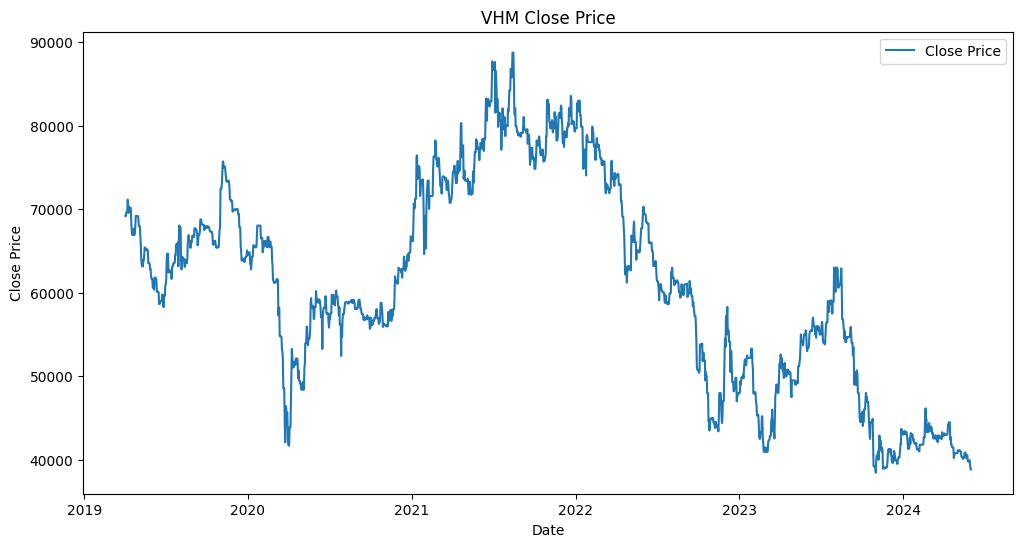

In [23]:
# Plot stock data
plot_stock_data(data, 'VHM Close Price')

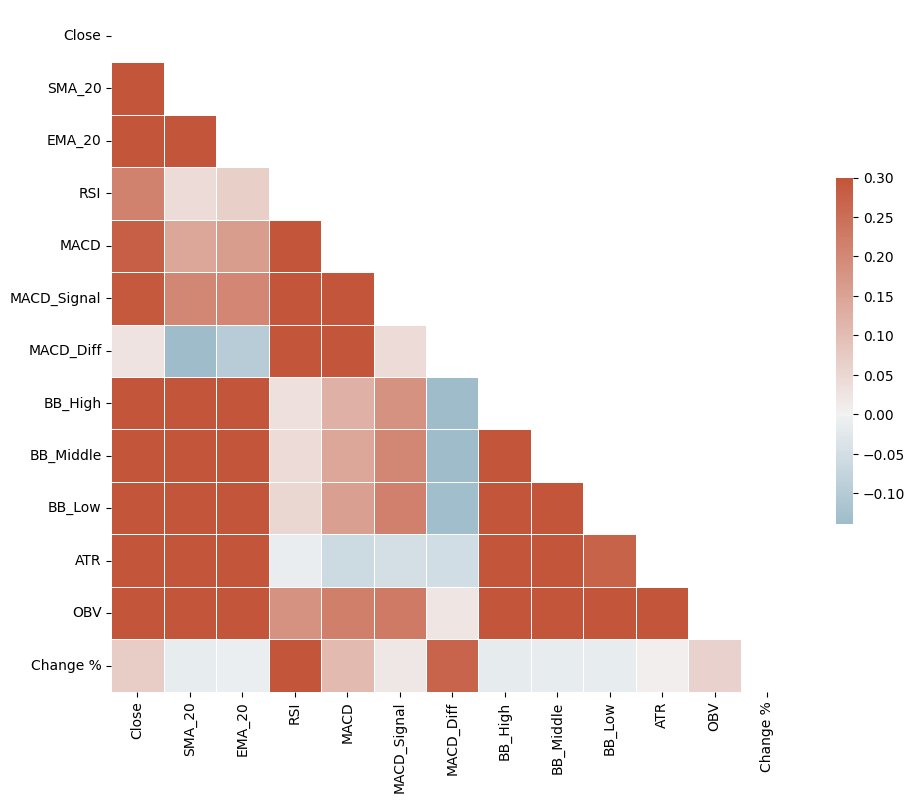

In [24]:

import seaborn as sns
import matplotlib.pyplot as plt

# Select 'Close' and the technical indicators
selected_data = data[['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Middle', 'BB_Low', 'ATR', 'OBV', 'Change %']]

# Compute the correlation matrix
corr = selected_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


In [25]:
X = data[['SMA_20', 'MACD_Signal']]
y = data['Close'].shift(-1)
X = X[:-1]
y = y[:-1]
print(y)

Date1
2019-04-03    69173.0
2019-04-04    69624.0
2019-04-05    69624.0
2019-04-06    69624.0
2019-04-07    71128.0
               ...   
2024-05-26    39800.0
2024-05-27    39950.0
2024-05-28    39450.0
2024-05-29    39000.0
2024-05-30    38850.0
Name: Close, Length: 1885, dtype: float64


In [26]:

# Define the proportion of data for training 
train_size = int(len(data) * 0.7)

# Split the data into training and test sets based on the proportion
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

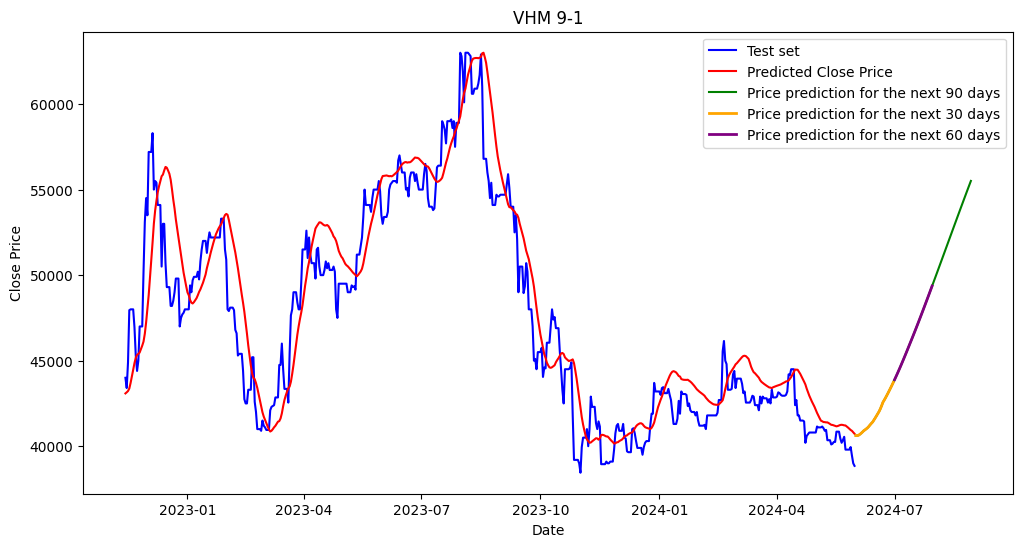

In [27]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)




# Get the last date from the dataset
last_date = data['Date'].iloc[-1]

# Create a copy of the data for predictions
future_data = data.copy()

# Predict the next 90 days
for i in range(90):
    # Get the last available data for prediction
    last_row = future_data.iloc[-1]
    
    # Create a DataFrame with the last row
    input_data = pd.DataFrame([last_row])
    # Select only the necessary features
    input_X = input_data[['SMA_20', 'MACD_Signal']]
    # Predict the next close price
    next_close = model.predict(input_X)[0]
    
    # Calculate the next date
    next_date = last_date + pd.DateOffset(days=1)
    
    # Add the prediction to the future_data DataFrame
    new_row = pd.Series({
        'Date': next_date,
        'Close': next_close,
        'SMA_20': future_data['Close'].rolling(window=20).mean().iloc[-1],  # Update with the new SMA
        'MACD_Signal': talib.MACD(future_data['Close'].astype('float64').values, fastperiod=12, slowperiod=26, signalperiod=9)[1][-1]
    })
    
    future_data = pd.concat([future_data, new_row.to_frame().T], ignore_index=True)
    # Update last_date
    last_date = next_date

# Plot the actual close prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][train_size+1:], data['Close'][train_size+1:], label='Test set', color='blue')
plt.plot(data['Date'][train_size+1:], y_pred, label='Predicted Close Price', color='red')
plt.plot(future_data['Date'][-90:], future_data['Close'][-90:], label='Price prediction for the next 90 days', color='green')
plt.plot(future_data['Date'][-90:-60], future_data['Close'][-90:-60], label='Price prediction for the next 30 days', color='orange', linewidth=2)
plt.plot(future_data['Date'][-60:-30], future_data['Close'][-60:-30], label='Price prediction for the next 60 days' ,color='purple', linewidth=2)
plt.title('VHM 9-1')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [28]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)
# Calculate MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)
# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', mape)


RMSE: 2291.0105586111044
MAE: 1763.6618134130658
MAPE: 3.7179800131565757
